### Importing dependencies

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Dataset Dependencies
from tensorflow.keras.datasets import mnist
from sklearn.utils import shuffle



### Loading Trainset and Testset

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the pixel values to the range [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Neural network structure

### Auxiliar functions

In [8]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def loss_func(label, pred):
    return 0.5*(label - pred)**2


### Neural network class

In [12]:
class NN():
    def __init__(self, params):
        self.params = params # format: [input_size, a1_size, a1_size, ...  output_size]

        # For all the lists, each element is a matrix of values for 1 layer

        # This list holds the activtions for just 1 pass (the forward calculates and resets it everytime it executes)
        self.activations_list = []  # [input_vector , a1_vector, a2_vector, ... output_vector]
        # This lists holds the weiths and biases until they are updated by the optimization() method
        self.weight_list = [np.random.normal(size=[params[i], params[i+1]], loc = 0.0, scale = 1.0) for i in range(len(params)-1)]
        self.bias_list = [np.random.normal(size=[params[i+1],], loc = 0.0, scale = 1.0) for i in range(len(params)-1)]
        # This list hold the cumulated weights and biases of the whole net for 1 batch
        self.dLdw_list_acumulated =  [0]*(len(params)-1) 
        self.dLdb_list_acumulated =  [0]*(len(params)-1) 
        # This lists hold the cumulated momentums factor (for Adam opttimizer) for the whole
        self.m_b = [0]*(len(params)-1) 
        self.m_w = [0]*(len(params)-1) 
        # This lists hold the cumulated RMSProp factors (for adam optimizer)
        self.r_w = [0]*(len(params)-1) 
        self.r_b = [0]*(len(params)-1) 

        print(" ----- Neural net layout -----")
        print(f"    Input with {params[0]} valeus")
        for i in range(len(self.params)-2):
            print(f"    Hidden layer {i+1} with {params[i+1]} nodes")
        print(f"    Output with {params[-1]} nodes")
        print(" -----------------------------")

    def reset_cumulated_gradients(self):
        self.dLdw_list_acumulated =  [0]*(len(self.params)-1) # initial value
        self.dLdb_list_acumulated =  [0]*(len(self.params)-1) # initial value

    def reset_cumulated_adam_factors(self):
        self.m_b = [0]*(len(self.params)-1) 
        self.r_w = [0]*(len(self.params)-1) 
        self.r_b = [0]*(len(self.params)-1) 
        self.m_w = [0]*(len(self.params)-1) 

    def forward(self, input):
        self.activations_list = [input] # Creates a list for the activation with the input vector as it is the a0 layers
        for i in range(len(self.params)-1): # Adds the other layers (n-1)layers because the input has been added already
            zi = np.dot(np.transpose(self.weight_list[i]), self.activations_list[i]) + self.bias_list[i]
            ai = sigmoid(zi)
            self.activations_list.append(ai)
        return ai

    def backpropagation(self, label, batch_size):
        # This function runs for every sample and the for iterates over every layer to cover the whlole nertowek

        # Each elemnt of this list is a matrix of weight for one layer OBS: the values are gonna be added from the last to the first item
        # The list represents the weights of the whole net for 1 sample
        dLdw_list = [] 
        dLdb_list = [] 

        for i in range(len(self.params)-1): # iters over all hidden layers and the output    ->   len(params)-1 
            if i == 0: # If the first calculation -> calculates dLdout
                output = self.activations_list[::-1][i]
                dLdout = (output - label)

                dadz = self.activations_list[::-1][i]*(1 - self.activations_list[::-1][i])
                cumulative_partials = dadz*dLdout # initial value
            else: # For all the other derivatives exept the last one
                dzda = self.weight_list[::-1][i-1]

                dadz = self.activations_list[::-1][i]*(1 - self.activations_list[::-1][i])
                cumulative_partials = dadz*np.dot(dzda, cumulative_partials)

            dzdw = self.activations_list[::-1][i+1] # element l-1 in the NN standard notation, but because the list in inverted, its index is i+1
            dzdb = 1

            transp_cumulative_partials = np.transpose(cumulative_partials.reshape(-1,1))

            gradient_w = np.dot(dzdw.reshape(-1,1), transp_cumulative_partials)
            gradient_b = dzdb*cumulative_partials
            
            # Append the gradient matrix for one layer
            dLdw_list.append(gradient_w)
            dLdb_list.append(gradient_b)

            self.dLdw_list_acumulated[i] += gradient_w/batch_size
            self.dLdb_list_acumulated[i] += gradient_b/batch_size

            # ----- Requirements for the Adam optimizer -------
            
            gama = 0.9
            beta = 0.999

            self.m_w[i] = gama*self.m_w[i] + (1 - gama)*self.dLdw_list_acumulated[::-1][i]
            self.m_b[i] = gama*self.m_b[i] + (1 - gama)*self.dLdb_list_acumulated[::-1][i]

            self.r_w[i] = beta*self.r_w[i] + (1 - beta)*self.dLdw_list_acumulated[::-1][i]**2
            self.r_b[i] = beta*self.r_b[i] + (1 - beta)*self.dLdb_list_acumulated[::-1][i]**2


    def optimization(self, alpha):
        # This function runs every batch
        e = 10e-8
        for i in range(len(self.weight_list)):
            
            self.weight_list[i] -= alpha*self.m_w[i]/(e + np.sqrt(self.r_w[i]))
            self.bias_list[i] -= alpha*self.m_b[i]/(e + np.sqrt(self.r_b[i]))

 
        
        
    


### Training process

In [13]:
bla = NN([784, 16, 10])

 ----- Neural net layout -----
    Input with 784 valeus
    Hidden layer 1 with 16 nodes
    Output with 10 nodes
 -----------------------------


In [14]:
x = x_train[0]
y = y_train[0]

In [15]:
a0 = x.ravel()
output = bla.forward(a0)


In [16]:

target = np.zeros(10)
target[y] = 1


bla.backpropagation(target, 20)



In [17]:
bla.optimization(0.5)


In [21]:
bla.m_b[1]

array([ 0.00038268,  0.00032137,  0.00021971,  0.00036599,  0.00073638,
       -0.0002484 ,  0.0007331 ,  0.00065667,  0.00056492,  0.00071501])

In [ ]:
bla.reset_cumulated_gradients()

In [22]:
bla = NN([784, 16, 10])

batch_size = 1
epoch = 5
lr = 0.5


loss_list = []
for i in range(epoch):
    loss = 0
    loss_cumulated = 0
    # shuffle the training data for each epoch
    x_train_shuffled, y_train_shuffled = shuffle(x_train, y_train)

    for j in np.arange(batch_size, len(y_train)+1, batch_size):
        batch = zip(x_train[j-batch_size : j], y_train[j-batch_size : j])

        for x, y in batch:
            a0 = x.ravel()
            output = bla.forward(a0)

            target = np.zeros(10)
            target[y] = 1

            loss = 0.5*(target - output)**2
            loss_cumulated += sum(loss)/len(loss)

            

            bla.backpropagation(target, batch_size)

        bla.optimization(lr)
        bla.reset_cumulated_gradients()
    bla.reset_cumulated_adam_factors()
    epoch_loss = loss_cumulated/len(y_train)
    loss_list.append(epoch_loss)

    print(f"Epoch {(i+1)}/{epoch},  loss: {epoch_loss}")

    
    

 ----- Neural net layout -----
    Input with 784 valeus
    Hidden layer 1 with 16 nodes
    Output with 10 nodes
 -----------------------------
Epoch 1/5,  loss: 0.09096736491384463
Epoch 2/5,  loss: 0.09096500000003874
Epoch 3/5,  loss: 0.09096500000003874


KeyboardInterrupt: 

### Testing process

In [11]:
f = 0
v = 0
for i in range(x_test.shape[0]):
    x = x_test[i].ravel()
    y = y_test[i]
    output = bla.forward(x)
    # bla.reset()
    predicted = np.argmax(output)
    if predicted == y:
        v +=1
    else:
        f+=1
print(f"The model correctly predicted {v} out of {v+f} test cases, achieving an accuracy of {v / (v+f) * 100:.2f}%.")

The model correctly predicted 9146 out of 10000 test cases, achieving an accuracy of 91.46%.


# Visualization

### Loss visualization

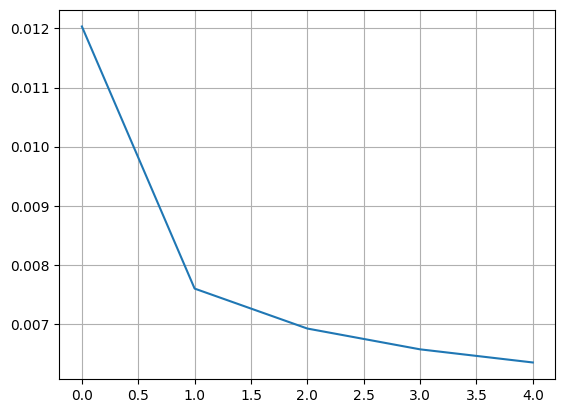

In [7]:
y_axis = loss_list
x_axis = [i for i in range(len(y_axis))]
plt.plot(x_axis, y_axis, )
plt.grid()
plt.show()

### Weights distribution

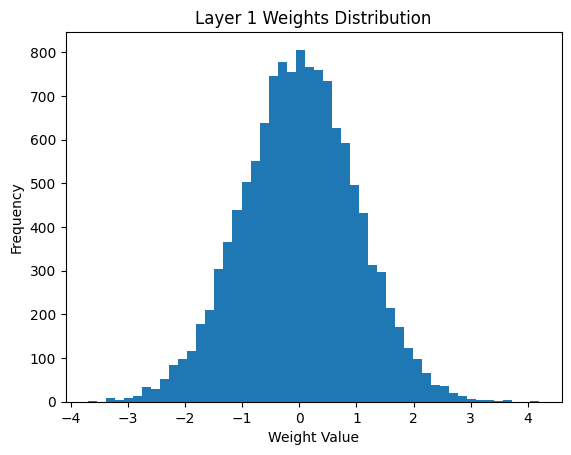

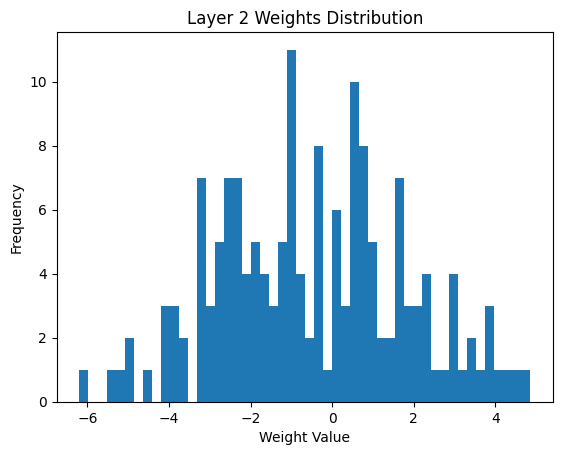

In [63]:
for i, layer_weights in enumerate(g.weight_list):
    plt.figure()
    plt.hist(layer_weights.flatten(), bins=50)
    plt.title(f'Layer {i+1} Weights Distribution')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.show()